In [1]:
from IPython.display import Image, display
from langchain_ollama import ChatOllama
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from pydantic import BaseModel

In [2]:
class State(BaseModel):
    topic: str
    story: str | None = None
    improved_story: str | None = None
    final_story: str | None = None


class GenerateStory:
    """Generate a one-sentence story premise based on a topic."""

    def __init__(self, llm: ChatOllama) -> None:
        self.llm = llm

    def __call__(self, state: State) -> dict:
        try:
            story = self.llm.invoke(
                f"Write a one sentence story premise about {state.topic}"
            )
            state.story = story.content
        except Exception as e:
            state.story = f"Error: {e}"
        return state.model_dump()


def check_for_conflict(state: State) -> str:
    """Check if the story contains conflict punctuation."""
    if isinstance(state.story, str) and ("?" in state.story or "!" in state.story):
        return "fail"
    return "pass"


class ImproveStory:
    """Enhance the story premise with vivid details."""

    def __init__(self, llm: ChatOllama) -> None:
        self.llm = llm

    def __call__(self, state: State) -> dict:
        try:
            improved = self.llm.invoke(
                f"Enhance this story premise with vivid details: {state.story}"
            )
            state.improved_story = improved.content
        except Exception as e:
            state.improved_story = f"Error: {e}"
        return state.model_dump()


class PolishStory:
    """Add an unexpected twist to the improved story."""

    def __init__(self, llm: ChatOllama) -> None:
        self.llm = llm

    def __call__(self, state: State) -> dict:
        try:
            final = self.llm.invoke(
                f"Add an unexpected twist to this story premise: {state.improved_story}"
            )
            state.final_story = final.content
        except Exception as e:
            state.final_story = f"Error: {e}"
        return state.model_dump()

In [3]:
llm = ChatOllama(model="qwen2.5")

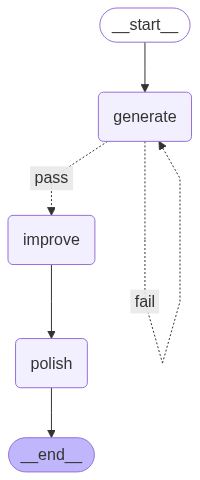

In [4]:
builder = StateGraph(State)
builder.add_node("generate", GenerateStory(llm))
builder.add_node("improve", ImproveStory(llm))
builder.add_node("polish", PolishStory(llm))

builder.add_edge(START, "generate")
builder.add_conditional_edges(
    "generate",
    check_for_conflict,
    {
        "pass": "improve",
        "fail": "generate",
    },
)
builder.add_edge("improve", "polish")
builder.add_edge("polish", END)

graph = builder.compile(checkpointer=MemorySaver())

display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
result = graph.invoke(
    dict(topic="Peter Parker got into a bar and..."),
    config={"configurable": {"thread_id": "1"}},
)

In [7]:
print(result.get("final_story"))

That's a gripping premise! To add an unexpected twist, let’s introduce a plot element that dramatically alters the course of events. Here’s how it can be done:

---

Peter Parker, disguised meticulously as his alter ego Spider-Man, stepped through the dimly lit door of the exclusive underground club "The Velvet Web," his heart pounding with both excitement and trepidation. The low murmur of voices and subtle hum of music filled the air as he slipped past the bouncer who barely glanced at him, too preoccupied to notice the web-slinger’s entrance.

Inside, the bar was a labyrinth of shadowy corners and glittering chandeliers. Neon lights flickered across the sleek, black surfaces and the faint scent of exotic tobacco hung in the air. Peter moved with practiced ease through the throngs of patrons, his spider-sense tingling as he sensed the tension beneath the surface.

As he navigated deeper into the club, a hush fell over the room. A group of shadowy figures, dressed in suits and fedoras